<!--NOTEBOOK_HEADER-->
*This notebook contains material from the [ND Pyomo Cookbook](http://jckantor.github.io/ND-Pyomo-Cookbook/) by 
Jeffrey Kantor (jeff at nd.edu); the content is available [on GitHub](https://github.com/jckantor/ND-Pyomo-Cookbook).
*The text is released under the [CC-BY-NC-ND-4.0 license](https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode),
and code is released under the [MIT license](https://opensource.org/licenses/MIT).*


<!--NAVIGATION-->
< [Scheduling Multipurpose Batch Processes using State-Task Networks](http://nbviewer.jupyter.org/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/04.04-Scheduling-Multipurpose-Batch-Processes-using-State-Task_Networks.ipynb) | [Contents](toc.ipynb) | [Index](index.ipynb) | [Simulation](http://nbviewer.jupyter.org/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/05.00-Simulation.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/04.05-Unit-Commitment.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>

# Unit Commitment

Keywords: semi-continuous variables, cbc usage, gdp, disjunctive programming

## Imports

In [92]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display, HTML

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("cbc") or os.path.isfile("cbc")):
    if "google.colab" in sys.modules:
        !apt-get install -y -qq coinor-cbc
    else:
        try:
            !conda install -c conda-forge coincbc 
        except:
            pass

assert(shutil.which("cbc") or os.path.isfile("cbc"))
import pyomo.environ as pyo
import pyomo.gdp as gdp

## Problem statement

A set of $N$ electrical generating units are available to meet a required demand $d_t$ for time period $t \in 1, 2, \ldots, T$. The power generated by unit $n$ for time period $t$ is denoted $x_{n,t}$.  Each generating unit is either off, $x_{n,t} = 0$ or else operating in a range $[p_n^{min}, p_n^{max}]$. The incremental cost of operating the generator during period $t$ is $a_n x_{n,t} + b_n$.

An binary variable variable $u_{n,t}$ indicates the operational state of a generating unit. 

The unit commmitment problem is given by

\begin{align*}
\min \sum_{n\in N} \sum_{t\in T} a_n x_{n,t} + b_n u_{n,t}
\end{align*}

subject to

\begin{align*}
\sum_{n\in N} x_{n,t} & = d_t \qquad \forall t \in T \\
p_{n}^{min}u_{n,t} & \leq x_{n,t} \qquad \forall n \in N, \ \forall t \in T \\
p_{n}^{max}u_{n,t} & \geq x_{n,t} \qquad \forall n \in N, \ \forall t \in T \\
\end{align*}

where we use the short-cut notation $T = [1, 2, \ldots T]$ and $N = [1, 2, \ldots, N]$.

This is a minimal model. A realistic model would include additional constraints corresponding to minimum up and down times for generating units, limits on the rate at which power levels can change, maintenance periods, and so forth.

* Sun, Xiaoling, Xiaojin Zheng, and Duan Li. ["Recent advances in mathematical programming with semi-continuous variables and cardinality constraint."](https://link.springer.com/article/10.1007/s40305-013-0004-0) Journal of the Operations Research Society of China 1, no. 1 (2013): 55-77.

## Model

### Demand

Text(0.5, 1.0, 'Demand')

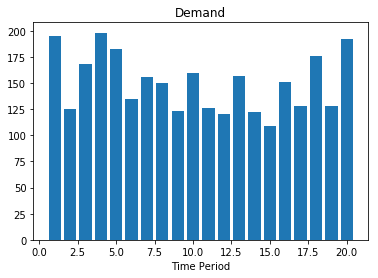

In [137]:
# demand
T = 20
T = np.array([t for t in range(0, T)])
d = np.array([100 + 100*np.random.uniform() for t in T])

fig, ax = plt.subplots(1,1)
ax.bar(T+1, d)
ax.set_xlabel('Time Period')
ax.set_title('Demand')

### Generating Units

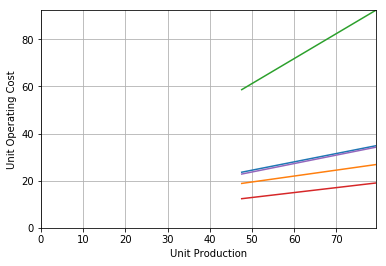

In [138]:
# generating units
N = 5
pmax = 2*max(d)/N
pmin = 0.6*pmax

N = np.array([n for n in range(0, N)])
a = np.array([0.5 + 0.2*np.random.randn() for n in N])
b = np.array([10*np.random.uniform() for n in N])

p = np.linspace(pmin, pmax)

fig, ax = plt.subplots(1,1)
for n in N:
    ax.plot(p, a[n]*p + b[n])
ax.set_xlim(0, pmax)
ax.set_ylim(0, max(a*pmax + b))
ax.set_xlabel('Unit Production')
ax.set_ylabel('Unit Operating Cost')
ax.grid()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 951.9361944
  Upper bound: 951.9361944
  Number of objectives: 1
  Number of constraints: 200
  Number of variables: 180
  Number of binary variables: 100
  Number of integer variables: 100
  Number of nonzeros: 180
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.06
  Wallclock time: 0.07
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
   

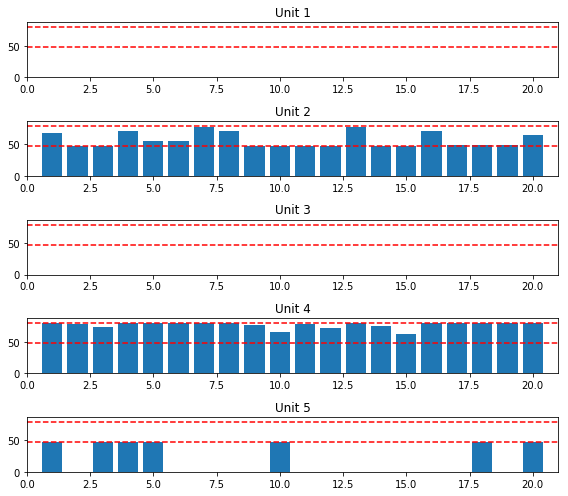

In [156]:
def unit_commitment():
    m = pyo.ConcreteModel()

    m.N = pyo.Set(initialize=N)
    m.T = pyo.Set(initialize=T)

    m.x = pyo.Var(m.N, m.T, bounds = (0, pmax))
    m.u = pyo.Var(m.N, m.T, domain=pyo.Binary)
    
    # objective
    m.cost = pyo.Objective(expr = sum(m.x[n,t]*a[n] + m.u[n,t]*b[n] for t in m.T for n in m.N), sense=pyo.minimize)
    
    # demand
    m.demand = pyo.Constraint(m.T, rule=lambda m, t: sum(m.x[n,t] for n in N) == d[t])
    
    # semi-continuous
    m.lb = pyo.Constraint(m.N, m.T, rule=lambda m, n, t: pmin*m.u[n,t] <= m.x[n,t])
    m.ub = pyo.Constraint(m.N, m.T, rule=lambda m, n, t: pmax*m.u[n,t] >= m.x[n,t])
    return m
   
m = unit_commitment()
pyo.SolverFactory('cbc').solve(m).write()

fig, ax = plt.subplots(max(N)+1, 1, figsize=(8, 1.5*max(N)+1))
for n in N:
    ax[n].bar(T+1, [m.x[n,t]() for t in T])
    ax[n].set_xlim(0, max(T)+2)
    ax[n].set_ylim(0, 1.1*pmax)
    ax[n].plot(ax[n].get_xlim(), np.array([pmax, pmax]), 'r--')
    ax[n].plot(ax[n].get_xlim(), np.array([pmin, pmin]), 'r--')
    ax[n].set_title('Unit ' + str(n+1))
fig.tight_layout()

In [162]:
def unit_commitment_gdp():
    m = pyo.ConcreteModel()

    m.N = pyo.Set(initialize=N)
    m.T = pyo.Set(initialize=T)

    m.x = pyo.Var(m.N, m.T, bounds = (0, pmax))
    
    
    # demand
    m.demand = pyo.Constraint(m.T, rule=lambda m, t: sum(m.x[n,t] for n in N) == d[t])
    
    m.sc1 = gdp.Disjunct(m.N, m.T, rule=lambda d, n, t: d.model().x[n,t] == 0)
    m.sc2 = gdp.Disjunct(m.N, m.T, rule=lambda d, n, t: d.model().x[n,t] >= pmin)
    m.sc = gdp.Disjunction(m.N, m.T, rule=lambda m, n, t: [m.sc1[n,t], m.sc2[n,t]])
    
    # objective
    m.cost = pyo.Objective(expr = sum(m.x[n,t]*a[n] + m.sc2[n,t].indicator_var*b[n] for t in m.T for n in m.N), sense=pyo.minimize)

    #m.semicontinuous = gdp.Disjunction(m.N, m.T, rule=lambda m, n, t: [m.x[n,t]==0, m.x[n,t] >= pmin])
    pyo.TransformationFactory('gdp.chull').apply_to(m)
    return m
   
m_gdp = unit_commitment_gdp()
pyo.SolverFactory('cbc').solve(m_gdp).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 706.017964
  Upper bound: 706.017964
  Number of objectives: 1
  Number of constraints: 20
  Number of variables: 100
  Number of binary variables: 200
  Number of integer variables: 200
  Number of nonzeros: 100
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.03
  Wallclock time: 0.09
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Br

In [161]:
m_gdp.pprint()

6 Set Declarations
    N : Dim=0, Dimen=1, Size=5, Domain=None, Ordered=False, Bounds=(0, 4)
        [0, 1, 2, 3, 4]
    T : Dim=0, Dimen=1, Size=20, Domain=None, Ordered=False, Bounds=(0, 19)
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
    sc1_index : Dim=0, Dimen=2, Size=100, Domain=None, Ordered=False, Bounds=None
        Virtual
    sc2_index : Dim=0, Dimen=2, Size=100, Domain=None, Ordered=False, Bounds=None
        Virtual
    sc_index : Dim=0, Dimen=2, Size=100, Domain=None, Ordered=False, Bounds=None
        Virtual
    x_index : Dim=0, Dimen=2, Size=100, Domain=None, Ordered=False, Bounds=None
        Virtual

1 Var Declarations
    x : Size=100, Index=x_index
        Key     : Lower : Value     : Upper             : Fixed : Stale : Domain
         (0, 0) :     0 : 36.177228 : 79.28162921368032 : False : False :  Reals
         (0, 1) :     0 :       0.0 : 79.28162921368032 : False : False :  Reals
         (0, 2) :     0 : 9.4649021 : 79.281

<!--NAVIGATION-->
< [Scheduling Multipurpose Batch Processes using State-Task Networks](http://nbviewer.jupyter.org/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/04.04-Scheduling-Multipurpose-Batch-Processes-using-State-Task_Networks.ipynb) | [Contents](toc.ipynb) | [Index](index.ipynb) | [Simulation](http://nbviewer.jupyter.org/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/05.00-Simulation.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/04.05-Unit-Commitment.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>